# Step 3 - Optimization with uncertain 𝛼 functions

This notebook aims to show the obtained results of developing a learner which works with aggregated data and unknown 𝛼 functions. The learner will have to estimate these functions while trying to make the best predictions in order to minimize regret. 

This learner employs a Multi Armed Bandit algorithm at its core, implemented via a Gaussian Process, in order to exploit continuity between the different arms. The learner will have 5 different Gaussian Processes, one for each subcampaign, since it has to estimate a unique 𝛼 function for each one of them.
As specified in the assignment, we implemented two different variations of the learner. One will combine Gaussian Processes with Thompson Sampling, the other will combine Gaussian Processes with UCB1.

#### Import statements
Used to import local functions/modules or external libraries inside the notebook.

In [1]:
from ola2022_project.environment.environment import example_environment, Step, UserClassParameters
from ola2022_project.simulation.simulation import Simulation, create_n, simulate_n
from ola2022_project.learners import *
from ola2022_project.algorithms.multi_armed_bandits import Mab
from ola2022_project.algorithms.reward_estimator import clairvoyant_reward

import numpy as np
import matplotlib.pyplot as plt
import random

plt.style.use('seaborn-v0_8-dark')

#### Plotting functions
Functions used to plot data onto a graph for an immediate visualization and analysis.

In [2]:
def compute_regret(rewards, avg_clairvoyant_reward):
    regret = avg_clairvoyant_reward - rewards
    regret[regret<0] = 0
    return np.cumsum(regret)


In [3]:
# Function used for quickly plotting multiple experiments onto a graph
def plot_experiment(n_days, rewards, avg_clairvoyant_reward, title, reward_color='cornflowerblue', regret_color='salmon'):

    regret_plot = compute_regret(rewards, avg_clairvoyant_reward)
    clairvoyant_plot = np.ones(len(rewards)) * avg_clairvoyant_reward

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

    ax[0].plot(rewards, color=reward_color, label='Rewards')
    ax[0].title.set_text(f'{title} reward')
    ax[0].plot(clairvoyant_plot, color=reward_color, linestyle='--', label='Average clairvoyant reward')
    ax[0].legend(loc='best')

    ax[1].plot(regret_plot, color=regret_color)
    ax[1].title.set_text(f'{title} regret')
        
    plt.show()

### Environment setup
We will run both learners in the same exact environment.

In [4]:
# This function exists because jupyter seems to be caching values and does not allow 
# repeatibility in the same notebook
def make_env(rng):
    classes_parameters=[
            [
                UserClassParameters(10, 0.2, 120),
                UserClassParameters(10, 0.15, 120),
                UserClassParameters(8, 0.5, 300),
                UserClassParameters(7, 0.05, 220),
                UserClassParameters(14, 0.15, 170),
            ],
            [
                UserClassParameters(22, 0.5, 190),
                UserClassParameters(20, 0.1, 210),
                UserClassParameters(16, 0.25, 240),
                UserClassParameters(24, 0.03, 80),
                UserClassParameters(20, 0.05, 360),
            ],
            [
                UserClassParameters(33, 0.4, 180),
                UserClassParameters(25, 0.15, 210),
                UserClassParameters(30, 0.35, 240),
                UserClassParameters(31, 0.05, 300),
                UserClassParameters(36, 0.05, 420),
            ],
        ]

    # Creating the environment
    env = example_environment(
        rng=rng,
        total_budget=400,
        class_ratios=[0.3, 0.6, 0.1],
        product_prices=[3, 15, 8, 22, 1],
        classes_parameters=classes_parameters,
        lam=0.5,
        max_items=3,
        graph_fully_connected=True,
        graph_zeros_probability=0.5,
        next_products=[(2, 3), (0, 2), (1, 4), (4, 1), (3, 0)],
        random_noise=1e-3,
        graph=np.array(
            [
                [0, 0, 0.7, 0.4, 0],
                [0.3, 0, 0.8, 0, 0],
                [0, 0.2, 0, 0, 0.2],
                [0, 0.9, 0, 0, 0.8],
                [0.05, 0, 0, 0.25, 0],
            ]
        ),
    )
    return env

In [5]:
# Random Number Generator used as a source of randomness by the environment and the simulation
seed =  1403
rng = np.random.default_rng(seed)

In [6]:
# Creating the environment
env = make_env(rng)

#### Default parameters

In [7]:
# Simulation separated default parameters
sim_n_days = 50
avg_clairvoyant_reward = clairvoyant_reward(env, 1000, 400, 20)

## GP Thompson Sampling implementation

In [8]:
# Creating the simulation
simulation = Simulation(
    rng,
    env,
    step=Step.ONE,
    n_budget_steps=20,
    population_mean=1000,
    population_variance=10,
    mab_algorithm=Mab.GPTS,
)

In [9]:
# Running the simulation
simulation.simulate(sim_n_days)
ts_rewards = simulation.rewards

days:   0%|          | 0/50 [00:00<?, ?it/s]

### Results

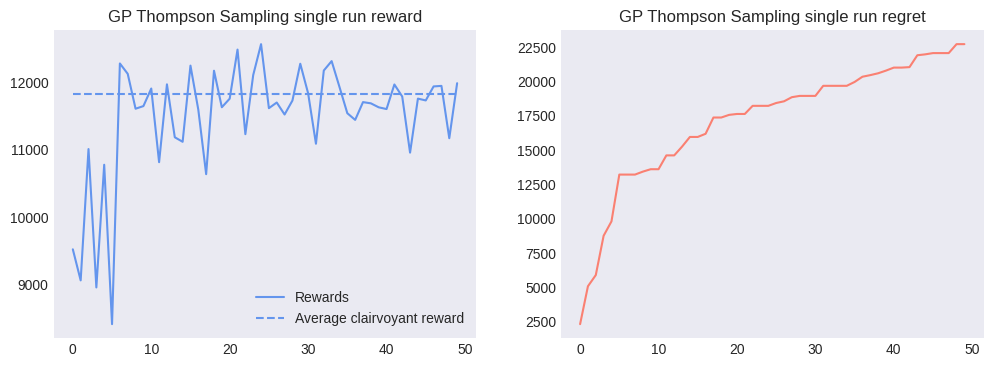

In [10]:
# Plotting the experiment
plot_experiment(sim_n_days, ts_rewards, avg_clairvoyant_reward, 'GP Thompson Sampling single run')

Here we can see a plot of the reward for each day of simulation and the corresponding regret.
As we can see the learner reaches the optimal superarm very quickly (8 days roughly). As expected from Thompson Sampling, we observe a bit of instability sometimes. This is because the MAB can occasionally choose a suboptimal arm due to the random nature of the algorithm.

Note: the reward sometimes is higher than the clairvoyant line. This something we expect since the environment leverages randomness to a certain extent. Therefore, since the clairvoyant reward is computed deterministically the reward, out of pure luck, can be higher.

## GP UCB1 implementation

In [11]:
rng = np.random.default_rng(seed=1401)
env = make_env(rng)

In [12]:
# Creating the simulation
simulation = Simulation(
    rng,
    env,
    step=Step.ONE,
    n_budget_steps=20,
    population_mean=1000,
    population_variance=10,
    mab_algorithm=Mab.GPUCB1,
)

In [13]:
# Running the simulation
simulation.simulate(sim_n_days)
ucb1_rewards = simulation.rewards

days:   0%|          | 0/50 [00:00<?, ?it/s]

### Results

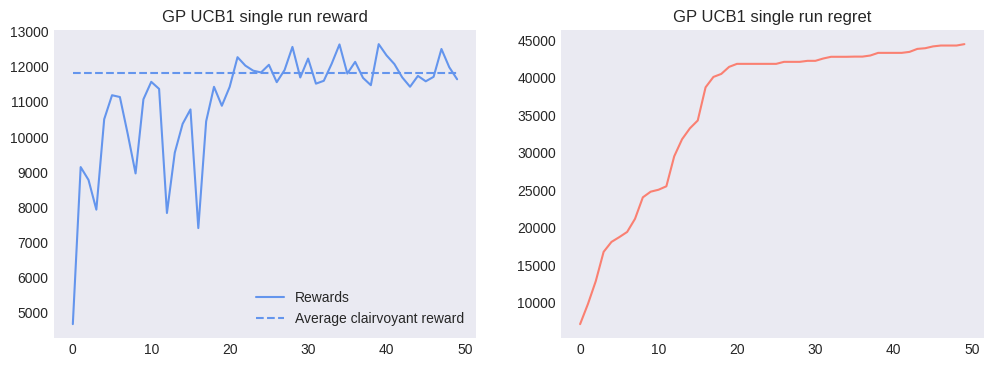

In [14]:
# Plotting the experiment
plot_experiment(sim_n_days, ucb1_rewards, avg_clairvoyant_reward, 'GP UCB1 single run')

The GP-UCB1 takes more time to get the optimal solution, but reaches it nontheless. However, we can observe a "jagged" behaviour. This is something that can be easily explained by the theory behind UBC1. In fact, UCB1 will chose the arm with the highest sum of mean and confidence bound. After pulling an arm a couple of times, its confidence bound shrinks and the mean becomes more accurate. After this, it can happen that another arm, which is sub-optimal, has a larger confidence bound since it has not been pulled much. In this case, UCB1 will play this arm. So, the periodic dips we see is the UCB1 algorithm playing sub-optimal arms with large enough confidence bounds.

## Comparison
Let's compare the performance of the two implementations.

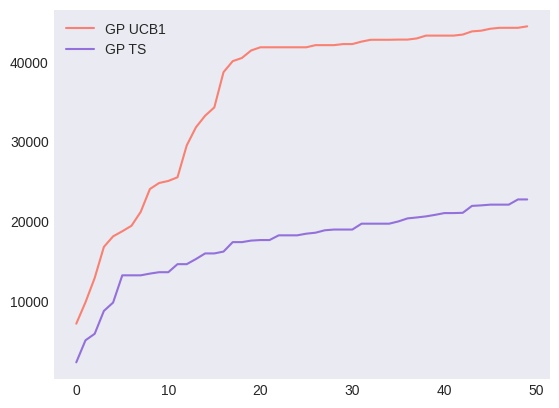

In [15]:
ucb1_regret = compute_regret(ucb1_rewards, avg_clairvoyant_reward)
ts_regret = compute_regret(ts_rewards, avg_clairvoyant_reward)

plt.plot(ucb1_regret, color='salmon', label='GP UCB1')
plt.plot(ts_regret, color='mediumpurple', label='GP TS')
plt.legend()

We can clearly see that the Thompson sampling implementation performs better, since it converges way faster, leading to a smaller regret overall. After enough days, both algorithms are able to converge to the optimal solution.

# Average Behaviour
Now we compute average reward and regret (including standard deviation) over a significant number of runs.

In [16]:
# Function used for quickly plotting multiple experiments onto a graph
def plot_avg_experiments(n_days, n_rewards, avg_clairvoyant_reward, title, reward_color='cornflowerblue', regret_color='salmon', std_color='salmon'):

    avg_reward = np.average(n_rewards, axis=0)
    std_reward = np.std(n_rewards, axis=0)
    x = np.arange(n_days)

    avg_regret = avg_clairvoyant_reward - avg_reward
    avg_regret[avg_regret<0] = 0
    avg_regret = np.cumsum(avg_regret)
    
    upper_std_regret = avg_clairvoyant_reward - avg_reward + std_reward
    upper_std_regret[upper_std_regret<0] = 0
    upper_std_regret = np.cumsum(upper_std_regret)

    lower_std_regret = avg_clairvoyant_reward - avg_reward - std_reward
    lower_std_regret[lower_std_regret<0] = 0
    lower_std_regret = np.cumsum(lower_std_regret)

    clairvoyant_plot = np.ones(len(avg_reward)) * avg_clairvoyant_reward

    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

    ax[0].plot(avg_reward, color=reward_color, label='Rewards')
    ax[0].title.set_text(f'{title} average reward over {len(n_rewards)} experiments')
    ax[0].plot(clairvoyant_plot, color=reward_color, linestyle='--', label='Average clairvoyant reward')
    ax[0].legend(loc='best')

    ax[0].fill_between(x, (avg_reward-std_reward), (avg_reward+std_reward), color=std_color, alpha=.1, label= 'std')

    ax[1].plot(avg_regret, color=regret_color)
    ax[1].title.set_text(f'{title} average regret over {len(n_rewards)} experiments')

    ax[1].fill_between(x, lower_std_regret, upper_std_regret, color=std_color, alpha=.1)
        
    plt.show()

In [17]:
rng = np.random.default_rng(seed)
env = make_env(rng)

In [18]:
sim_n_experiments = 15
n_days = 50
seed = 1403

# Creating multiple simulations
simulations = create_n(
    rng,
    env,
    step=Step.ONE,
    n=sim_n_experiments,
    n_budget_steps=20,
    population_mean=1000,
    population_variance=10,
    mab_algorithm=Mab.GPTS,
)

In [19]:
ts_rewards = simulate_n(simulations, n_days)

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

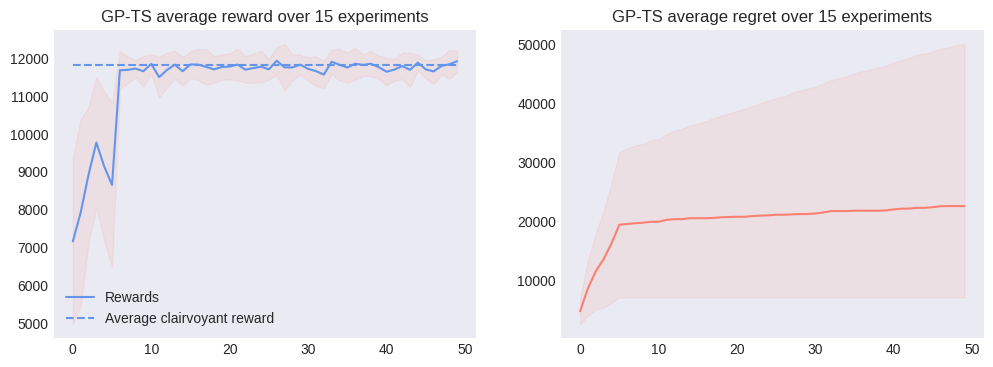

In [20]:
plot_avg_experiments(n_days, 
    ts_rewards,
    avg_clairvoyant_reward, 
    'GP-TS')

In [21]:
# Computing empiric regret
avg = np.average(ts_rewards, axis=0)
total_rew = np.sum(avg)
empiric_regret = avg_clairvoyant_reward * n_days - total_rew

print(f'GPTS empiric regret over a {n_days} days horizon: {empiric_regret}')

GPTS empiric regret over a 50 days horizon: 21939.533333333326


In [22]:
# Creating multiple simulations
simulations = create_n(
    rng,
    env,
    step=Step.ONE,
    n=sim_n_experiments,
    n_budget_steps=20,
    population_mean=1000,
    population_variance=10,
    mab_algorithm=Mab.GPUCB1,
)

In [23]:
ucb1_rewards = simulate_n(simulations, n_days, )

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

days:   0%|          | 0/50 [00:00<?, ?it/s]

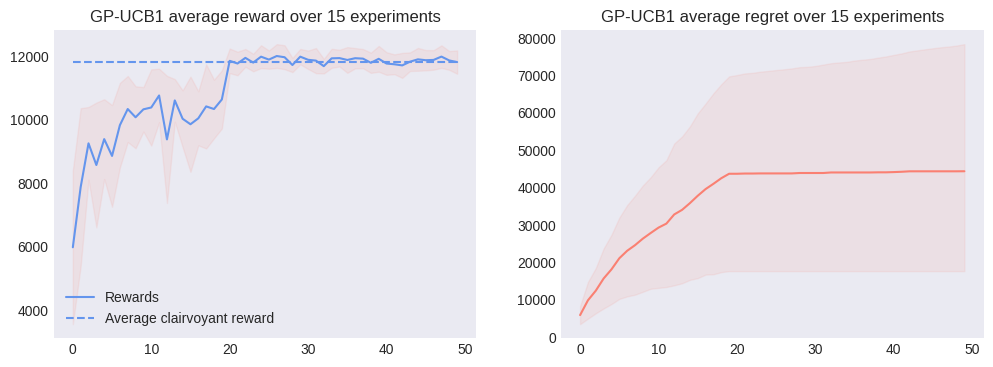

In [24]:
plot_avg_experiments(n_days, 
    ucb1_rewards,
    avg_clairvoyant_reward, 
    'GP-UCB1')

In [25]:
# Computing empiric regret
avg = np.average(ucb1_rewards, axis=0)
total_rew = np.sum(avg)
empiric_regret = avg_clairvoyant_reward * n_days - total_rew

print(f'GPUCB1 empiric regret over a {n_days} days horizon: {empiric_regret}')

GPUCB1 empiric regret over a 50 days horizon: 42543.60000000009


## Average regret comparison

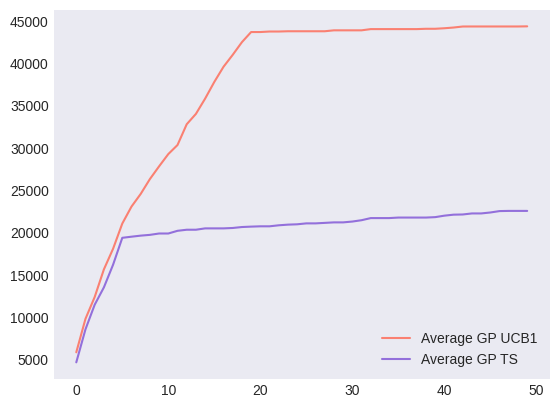

In [26]:
ucb1_regret = compute_regret(np.average(ucb1_rewards, axis=0), avg_clairvoyant_reward)
ts_regret = compute_regret(np.average(ts_rewards, axis=0), avg_clairvoyant_reward)

plt.plot(ucb1_regret, color='salmon', label='Average GP UCB1')
plt.plot(ts_regret, color='mediumpurple', label='Average GP TS')
plt.legend()